In [15]:
import pandas as pd
import numpy as np
import random
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from keras.layers import Flatten, Conv1D, MaxPooling1D, Activation, concatenate, BatchNormalization, Add
from keras.layers import Dense, LSTM, Embedding, Bidirectional, Input, Dropout
from keras.models import Model

from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
seed=42

In [5]:
df=pd.read_csv('features_flight_heli.csv')
df.dropna(inplace=True)
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6865 entries, 0 to 6864
Data columns (total 6 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   fname        6865 non-null   object 
 1   alt_max      6865 non-null   float64
 2   vert_acc     6865 non-null   float64
 3   horiz_speed  6865 non-null   float64
 4   dist         6865 non-null   float64
 5   is_maneuver  6865 non-null   int64  
dtypes: float64(4), int64(1), object(1)
memory usage: 321.9+ KB


In [6]:
df.drop(['fname'], axis=1, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6865 entries, 0 to 6864
Data columns (total 5 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   alt_max      6865 non-null   float64
 1   vert_acc     6865 non-null   float64
 2   horiz_speed  6865 non-null   float64
 3   dist         6865 non-null   float64
 4   is_maneuver  6865 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 268.3 KB


In [7]:
df['is_maneuver'].value_counts()

1    5104
0    1761
Name: is_maneuver, dtype: int64

In [8]:
Y = df['is_maneuver']
X = df.drop(['is_maneuver'], axis=1)

print(X.shape)
print(Y.shape)

(6865, 4)
(6865,)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, stratify=Y, random_state=seed)

In [12]:
df.head()

,alt_max,vert_acc,horiz_speed,dist,is_maneuver
0,9479.0,-0.143793,241.277903,12.318341,0
1,10104.0,0.537735,171.344710,17.558203,1
2,3650.0,-1.418815,123.471539,0.605749,1
3,9479.0,-0.000318,235.397455,13.761831,1
4,10066.0,-0.208709,135.173804,13.815511,1


In [19]:
X_train = np.array(X_train)
X_test=np.array(X_test)

In [97]:



mean = X_train.mean(axis=0)
std = X_train.std(axis=0)
X_train = (X_train - mean) / std

inputs = Input(shape=(X_train.shape[1],))

# Initial dense layers
x = Dense(256)(inputs)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(128)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Residual connection starts here
residual = x

x = Dense(64)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(32)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

x = Dense(16)(x)
x = Activation('relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)

# Residual connection
residual = Dense(16)(residual)
x = Add()([x, residual])
x = Activation('relu')(x)

# Output layer
outputs = Dense(1, activation='sigmoid')(x)

# Create the model
model2 = Model(inputs=inputs, outputs=outputs)

# Compile the model
optimizer = Adam(learning_rate=0.0001)
model2.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Train the model
history2 = model2.fit(X_train, y_train, epochs=20, batch_size=64, validation_split=0.2, callbacks=[early_stopping])


Epoch 1/20
69/69 [==============================] - 4s 20ms/step - loss: 0.9873 - accuracy: 0.5188 - val_loss: 0.7256 - val_accuracy: 0.2994
Epoch 2/20
69/69 [==============================] - 1s 13ms/step - loss: 0.8081 - accuracy: 0.6239 - val_loss: 0.7214 - val_accuracy: 0.3458
Epoch 3/20
69/69 [==============================] - 0s 7ms/step - loss: 0.7310 - accuracy: 0.6754 - val_loss: 0.6652 - val_accuracy: 0.5396
Epoch 4/20
69/69 [==============================] - 0s 7ms/step - loss: 0.6538 - accuracy: 0.7282 - val_loss: 0.5882 - val_accuracy: 0.7361
Epoch 5/20
69/69 [==============================] - 0s 7ms/step - loss: 0.6210 - accuracy: 0.7382 - val_loss: 0.5088 - val_accuracy: 0.8016
Epoch 6/20
69/69 [==============================] - 0s 7ms/step - loss: 0.5737 - accuracy: 0.7639 - val_loss: 0.4552 - val_accuracy: 0.8326
Epoch 7/20
69/69 [==============================] - 0s 6ms/step - loss: 0.5365 - accuracy: 0.7819 - val_loss: 0.4240 - val_accuracy: 0.8471
Epoch 8/20
69/69 [

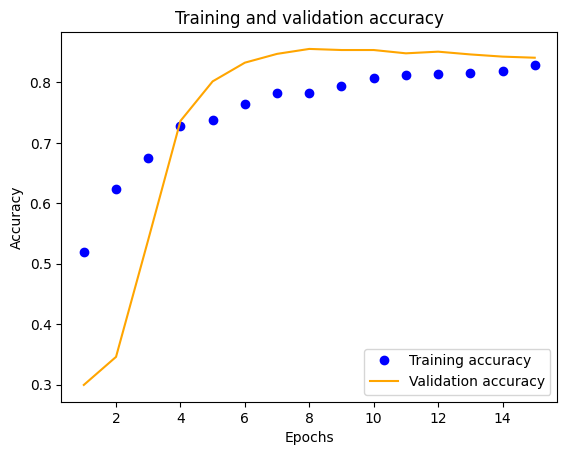

0.8553230166435242

In [98]:
acc = history2.history['accuracy']
val_acc = history2.history['val_accuracy']
epochs = range(1, len(acc) + 1)


plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'orange', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()


np.max(val_acc)